<a href="https://colab.research.google.com/github/LKXoro/BEDU-Rstudio-postworks/blob/main/M3_Postwork8/Postwork_08_python.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Postwork 08: Preparándose para las siguientes fases

Sea PandaScore_get_matches() la función que realiza peticiones a nuestra API sobre los enfrentamientos de un juego:

In [1]:
import pandas as pd 
import math as mt
from datetime import *
import requests 

def PandaScore_get_matches(juego): #Definimos nuestra función
    if isinstance(juego, str): #Nos aseguramos que los argumentos sean de tipo str
        informacion = 'matches'
        registros = 100 #Establecemos el número de registros por página
        token = 'V3U1fnnWozJi3bbhZfrxdiAmN4-XWnX_4g6i_6iauwwh7w-V8Ns' #Token de acceso
        url = f"https://api.pandascore.co/{juego}/{informacion}?page[size]={registros}&token={token}" #URL con los parámetros deseados
        response = requests.get(url) #Realizamos la petición
        if response.status_code == 200: #Si todo salió bien continuamos
            Iteraciones = mt.ceil(float(response.headers['X-Total'])/registros) #Calculamos el número de páginas en base a todos los registros que hay en la API
            #Al dividir el número total de registros entre los registros solicitados obtenemos un aproximado, para asegurar que tomaremos todos, redondeamos al entero más alto
            for i in range(1,Iteraciones+1): #Ciclo for para obtener todos los registros de cada página
                url = f"https://api.pandascore.co/{juego}/{informacion}?page[size]={registros}&page[number]={i}&token=V3U1fnnWozJi3bbhZfrxdiAmN4-XWnX_4g6i_6iauwwh7w-V8Ns"
                #URL el parámetro de página deseada
                response = requests.get(url) #Realizamos la petición correspondiente
                data = response.json() #Transformamos la respuesta 
                if i == 1: #En la primer iteración se crea un Dataframe
                    df_matches = pd.DataFrame.from_dict(data)
                else: #En el resto de iteraciones se van añadiendo los nuevos registros
                    df_matches = df_matches.append(pd.DataFrame.from_dict(data),ignore_index=True)                    
            return df_matches # Finalmente se devuelve el Dataframe con todos los registros limpios y ordenados
        else: #Si la petición no se ejecutó correctamente mandamos un mensaje con el error devuelto
            return 'Error de petición: '+str(response.status_code)  
    else: #Si los argumentos no son de tipo str regresamos un mensaje
        return 'Por favor coloque un argumento válido en formato string.'

Además, sea df_matches_clean() la función que elimnará campos indeseados:

In [4]:
def df_matches_clean(df_matches):
  ########### Limpieza de datos
   campos_no_deseados = ['videogame', 'slug', 'tournament', 'league', 'serie', 'streams', 'modified_at', 'games',
                      'game_advantage', 'scheduled_at', 'original_scheduled_at', 'detailed_stats','live',
                      'match_type', 'videogame_version', 'live_embed_url', 'id'] 

   df_matches_temp = df_matches.drop(columns=campos_no_deseados) #Limpiamos campos que no nos son de utilidad
   df_matches_finished = df_matches_temp[ df_matches_temp['status'] == 'finished' ] #Dejamos solo los enfrentamientos que han terminado
   df_matches_finished_clean = df_matches_finished.dropna(subset=['begin_at', 'end_at']) #Eliminamos algunos valores nulos de las fechas
   df_matches_ordenado = df_matches_finished_clean[['name','opponents','results','forfeit','draw', #Reorganizamos los campos
                                                      'number_of_games','winner','winner_id','begin_at','end_at', 
                                                      'rescheduled','official_stream_url','league_id', 'serie_id', 'tournament_id']]
   df_matches_ordenado = df_matches_ordenado.reset_index(drop=True) #Reseteamos el índice
   nombres_nuevos = {'name' : 'match_name',
                             'begin_at' : 'begin_date',
                             'end_at' : 'end_date',
                             'official_stream_url' : 'official_stream_channel_url'}                       
   df_matches_ordenado.rename(columns=nombres_nuevos, inplace=True) #Renombramos columnas 
   return df_matches_ordenado  

Junto a winner_team(),loser_team() y team_score() que añaden nuevos campos:

In [5]:
def winner_team(serie):
    if serie == None:
        return 'Undefined'
    else: return serie['name']

def loser_team(df):
    losers = []
    for i in range(0,len(df)):
        ganador = df['winner_team'][i]
        equipo = df['opponents'][i][0]['opponent']['name']
        if ganador == 'Undefined':
           losers.append('Undefined')
        elif equipo == ganador:
           losers.append(df['opponents'][i][1]['opponent']['name'])  
        elif equipo != ganador: 
           losers.append(df['opponents'][i][0]['opponent']['name'] )
    return pd.Series(losers,index=df.index)

def team_scores(df):
    losers_score = []
    winners_score = []
    for i in range(0,len(df)):
        ganador_id = df['winner_id'][i]
        equipo1_id = df['results'][i][0].get('team_id')
        equipo2_id = df['results'][i][1].get('team_id')
        if ganador_id == 0:
            winner_score = 0
            loser_score = 0
        elif equipo1_id == ganador_id:
            winner_score = df['results'][i][0].get('score')
            loser_score = df['results'][i][1].get('score')
        else:
            winner_score = df['results'][i][1].get('score')
            loser_score = df['results'][i][0].get('score')
        winners_score.append(winner_score)    
        losers_score.append(loser_score)
    return [pd.Series(winners_score,index=df.index), pd.Series(losers_score,index=df.index) ]


Y finalmente sea matches_shiny() la función que embellecé nuestro dataframe y arregla los tipos de dato:

In [7]:
def matches_shiny(juego_matches):
    juego_matches['winner_team'] = juego_matches['winner'].map(winner_team)
    juego_matches['loser_team'] = loser_team(juego_matches)  
    juego_matches['winner_id'] = juego_matches['winner_id'].fillna(0)
    juego_matches['official_stream_channel_url'] = juego_matches['official_stream_channel_url'].fillna('Not Provided')
    juego_matches['winner_id'] = juego_matches['winner_id'].astype(int)
    [winner_score,loser_score] = team_scores(juego_matches)
    juego_matches['winner_score'] = winner_score
    juego_matches['loser_score'] = loser_score
    campos_no_deseados = ['results','winner','opponents','winner_id']
    juego_matches = juego_matches.drop(columns=campos_no_deseados)
    juego_matches['begin_date'] = juego_matches['begin_date'].apply(datetime.strptime, args=('%Y-%m-%dT%H:%M:%SZ',))
    juego_matches['end_date'] = juego_matches['end_date'].apply(datetime.strptime, args=('%Y-%m-%dT%H:%M:%SZ',))
    ljuego_matches = juego_matches.sort_values('begin_date', ascending=True)
    juego_matches = juego_matches.reset_index(drop=True)
    return juego_matches

Llamamos a las funciones para obtener nuestro Dataframe de forma automática:

In [8]:
lol_matches_raw = PandaScore_get_matches('lol')
lol_matches_sin_nones = df_matches_clean(lol_matches_raw)
lol_matches = matches_shiny(lol_matches_sin_nones)

_lol matches_ se vuelve entonces uno de nuestros Dataframes destinado para el análisis de eSports:

In [9]:
lol_matches

,match_name,forfeit,draw,number_of_games,begin_date,end_date,rescheduled,official_stream_channel_url,league_id,serie_id,tournament_id,winner_team,loser_team,winner_score,loser_score
0,ALF vs BJD,False,False,1,2021-03-06 09:54:42,2021-03-06 10:28:54,False,https://www.twitch.tv/lolpacific,4288,3337,5483,Berjaya Dragons,Alpha Esports,1,0
1,Lower Bracket Round 2 Match 1: CGG vs GGE,False,False,5,2021-03-08 18:07:48,2021-03-08 21:37:26,False,https://www.twitch.tv/pg_esports,4405,3291,5579,GG&Esports,Cyberground Gaming,3,1
2,Round 1 match 1: KVM vs ION,False,False,5,2021-03-08 18:04:03,2021-03-08 20:46:01,False,https://www.twitch.tv/esportsprimelol,4401,3248,5609,KV Mechelen Esports,Ion Squad,3,0
3,Winners bracket round 1 match 2: ESB vs SIN,False,False,5,2021-03-07 17:53:43,2021-03-07 22:22:51,False,https://www.twitch.tv/hitpointcz,4433,3314,5602,SINNERS Esports,eSuba,3,2
4,Winners bracket round 1 match 1: IG vs VIK,False,False,5,2021-03-07 13:30:41,2021-03-07 17:08:57,False,https://www.twitch.tv/hitpointcz,4433,3314,5602,Inside Games,Vikingekrig Esports,3,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18111,DIG vs C9,False,False,1,2015-05-31 20:09:51,2015-05-31 20:43:55,False,Not Provided,289,31,1,Dignitas,Cloud9,1,0
18112,T8 vs TL,False,False,1,2015-05-31 18:22:58,2015-05-31 19:04:18,False,Not Provided,289,31,1,Team Liquid,Team 8,1,0
18113,GV vs NME,False,False,1,2015-05-30 23:23:25,2015-05-31 00:06:10,False,Not Provided,289,31,1,Enemy,Gravity,1,0
18114,T8 vs TIP,False,False,1,2015-05-30 22:23:32,2015-05-30 22:56:32,False,Not Provided,289,31,1,Impulse,Team 8,1,0


Gracias a nuestras funciones aportamos también otros Dataframe para los juegos de la API:

In [10]:
dota2_matches_raw = PandaScore_get_matches('dota2')
dota2_matches_sin_nones = df_matches_clean(dota2_matches_raw)
dota2_matches = matches_shiny(dota2_matches_sin_nones)

In [11]:
dota2_matches

,match_name,forfeit,draw,number_of_games,begin_date,end_date,rescheduled,official_stream_channel_url,league_id,serie_id,tournament_id,winner_team,loser_team,winner_score,loser_score
0,VK.gg vs SMASH,False,False,3,2021-03-08 21:12:14,2021-03-08 23:31:34,True,https://www.twitch.tv/dota2ruhub,4487,3393,5595,ViKin.gg,Hellbear Smashers,2,0
1,Empire vs PckCp,False,False,3,2021-03-08 17:36:02,2021-03-08 20:47:39,False,https://www.twitch.tv/dota2ruhub,4487,3393,5595,Team Empire,PuckChamp,2,1
2,EXTR vs Prosti Esli,False,False,3,2021-03-08 13:06:12,2021-03-08 17:19:19,False,https://www.twitch.tv/dota2ruhub,4487,3393,5595,Prosti Esli,EXTREMUM,2,1
3,Grand Final: SMG vs LBZS,False,False,5,2021-03-06 06:26:09,2021-03-06 08:54:38,True,https://www.twitch.tv/moonstudio_en,4535,3342,5575,LBZS,Team SMG,3,0
4,Lower Bracket Final: LBZS vs XctN,False,False,3,2021-03-05 11:18:31,2021-03-05 14:07:14,False,https://www.twitch.tv/moonstudio_en,4535,3342,5575,LBZS,Execration,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15257,Lower Round 3,False,False,3,2017-08-10 17:27:49,2017-08-10 18:58:23,False,Not Provided,4106,1380,919,Team Liquid,Team Empire,2,0
15258,Lower Round 4,False,False,3,2017-08-10 22:32:37,2017-08-11 02:30:40,False,Not Provided,4106,1380,919,Team Liquid,Virtus.pro,2,1
15259,Liquid vs iG.V,False,False,3,2017-08-02 16:06:08,2017-08-02 18:11:05,False,Not Provided,4106,1380,920,Team Liquid,iG.Vitality,2,0
15260,Empire vs iG.V,False,True,2,2017-08-04 20:22:44,2017-08-04 23:39:05,False,Not Provided,4106,1380,920,Undefined,Undefined,0,0


In [12]:
csgo_matches_raw = PandaScore_get_matches('csgo')
csgo_matches_sin_nones = df_matches_clean(csgo_matches_raw)
csgo_matches = matches_shiny(csgo_matches_sin_nones)

In [14]:
csgo_matches

,match_name,forfeit,draw,number_of_games,begin_date,end_date,rescheduled,official_stream_channel_url,league_id,serie_id,tournament_id,winner_team,loser_team,winner_score,loser_score
0,Quarterfinal 2: Team Unknown vs RBG,False,False,3,2021-03-09 01:09:42,2021-03-09 02:20:00,False,Not Provided,4321,3420,5654,RBG,Team Unknown,2,0
1,Quarterfinal 1: Levitate vs Rebirth Esports,False,False,3,2021-03-09 01:09:40,2021-03-09 02:28:31,False,Not Provided,4321,3420,5654,Rebirth Esports,Levitate,2,0
2,Round of 16 match 8: RBG vs ImPerium,False,False,3,2021-03-08 23:10:22,2021-03-09 00:47:36,False,Not Provided,4321,3420,5654,RBG,ImPerium,2,0
3,Round of 16 match 7: Team Unknown vs brüh,False,False,3,2021-03-08 23:09:48,2021-03-09 00:20:07,False,Not Provided,4321,3420,5654,Team Unknown,brüh,2,0
4,Round of 16 match 6: Pryde vs Tidal,False,False,3,2021-03-08 23:09:23,2021-03-09 01:41:45,False,Not Provided,4321,3420,5654,Pryde,Tidal,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15118,Astralis vs North,False,False,3,2017-10-26 11:45:00,2017-10-26 14:12:00,False,Not Provided,4156,1562,1698,Astralis,North,2,0
15119,Semifinals 1: SK vs Astralis,False,False,3,2017-10-28 09:50:00,2017-10-28 12:41:00,False,Not Provided,4156,1562,1518,SK,Astralis,2,0
15120,Semifinals 2: G2 vs Virtus.pro,False,False,3,2017-10-28 13:50:00,2017-10-28 16:25:00,False,Not Provided,4156,1562,1518,Virtus.pro,G2,2,1
15121,3rd Place Match: Astralis vs G2,False,False,3,2017-10-29 09:30:00,2017-10-29 12:15:00,False,Not Provided,4156,1562,1518,G2,Astralis,2,1


In [17]:
ow_matches_raw = PandaScore_get_matches('ow')
ow_matches_sin_nones = df_matches_clean(ow_matches_raw)
ow_matches = matches_shiny(ow_matches_sin_nones)

In [18]:
ow_matches

,match_name,forfeit,draw,number_of_games,begin_date,end_date,rescheduled,official_stream_channel_url,league_id,serie_id,tournament_id,winner_team,loser_team,winner_score,loser_score
0,Grand Final: SHD vs SEO,False,False,4,2021-01-31 12:06:52,2021-01-31 13:28:26,False,https://cc.163.com/260825191,4528,3303,5416,Shanghai Dragons,Seoul Dynasty,4,1
1,SEO vs DAL,False,False,3,2021-01-30 11:36:15,2021-01-30 13:20:39,False,https://cc.163.com/260825191/,4528,3303,5415,Dallas Fuel,Seoul Dynasty,3,2
2,GZC vs SHD,False,False,3,2021-01-30 10:09:01,2021-01-30 11:17:06,False,https://cc.163.com/260825191/,4528,3303,5415,Shanghai Dragons,Guangzhou Charge,3,0
3,SHD vs SEO,False,False,3,2021-01-24 11:22:49,2021-01-24 12:31:10,False,https://cc.163.com/260825191/,4528,3303,5415,Seoul Dynasty,Shanghai Dragons,3,1
4,DAL vs GZC,False,False,3,2021-01-24 10:10:31,2021-01-24 10:57:58,False,https://cc.163.com/260825191/,4528,3303,5415,Guangzhou Charge,Dallas Fuel,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1559,DAL vs HOU,False,False,5,2017-12-08 01:00:00,2017-12-08 03:25:00,False,Not Provided,4135,1500,658,Dallas Fuel,Houston Outlaws,3,2
1560,GLA vs LDN,False,False,5,2017-12-07 22:00:00,2017-12-08 00:45:00,False,Not Provided,4135,1500,658,Los Angeles Gladiators,London Spitfire,3,2
1561,SEO vs SHD,False,False,5,2017-12-07 04:30:00,2017-12-07 06:30:00,False,Not Provided,4135,1500,658,Seoul Dynasty,Shanghai Dragons,4,0
1562,VAL vs SFS,False,False,5,2017-12-07 02:00:00,2017-12-07 04:25:00,False,Not Provided,4135,1500,658,Los Angeles Valiant,San Francisco Shock,3,2


Podemos utilizar nuestro Dataframe para obtener datos interesantes que responden algunas preguntas que nos hicimos al comienzo. En un principio nos preguntabamos si los enfrentamientos de eSports son cortos o largos, aprovechemos el paquete _datetime_ y descubrámoslo:

In [40]:
def tiempo_partida(df):
    minutos_partidas=[]
    for n in range (0,len(df)):   
        inicio_enfrentamiento= df.loc[n,'begin_date'] 
        fin_enfrentamiento= df.loc[n,'end_date']
        total_partidas = df.loc[n,'number_of_games']
        duración_partidas = (fin_enfrentamiento-inicio_enfrentamiento)/total_partidas
        minutos = round(duración_partidas.total_seconds()/60,3)
        minutos_partidas.append(minutos)
  
    df['minutos_partidas'] = pd.Series(minutos_partidas)
    no_outlier = df['minutos_partidas'] > 0
    df= df[no_outlier]
    no_outlier = df['minutos_partidas'] < 100
    df_boxplot = df[no_outlier]   
          
    return df_boxplot 

La función anterior esta pensada para obtener la duración en minutos de las partidas, se nos devuelve el dataframe que usamos como argumento con nuevo campo y filtrado para partidas con tiempo mayor a 0 (tiempo positivo) y menor a 100 minutos (como jugones curtidos sabemos que 100 minutos es una partida exagerada por si sola). Veamos como se comportan los diferentes juegos con un gráfico llamativo:

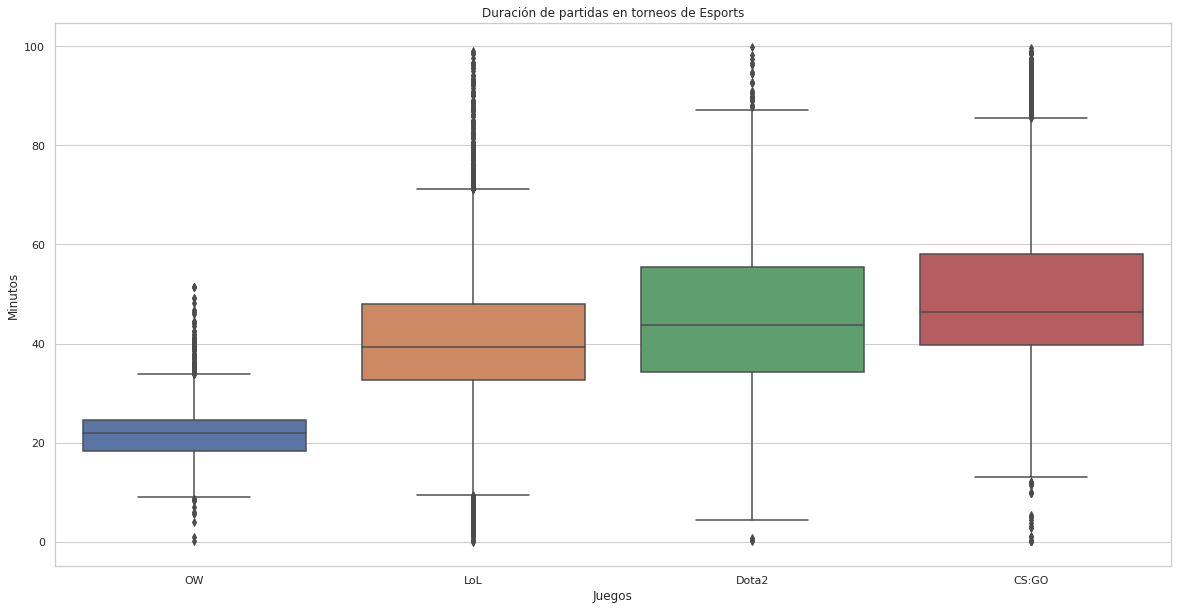

In [42]:
boxplot_lol = tiempo_partida(lol_matches)
boxplot_dota2 = tiempo_partida(dota2_matches)
boxplot_csgo = tiempo_partida(csgo_matches)
boxplot_ow = tiempo_partida(ow_matches)

import seaborn as sns

plt.figure(figsize=[20, 10])
sns.set(style="whitegrid")
sns.boxplot(data=[boxplot_ow['minutos_partidas'],boxplot_lol['minutos_partidas'],boxplot_dota2['minutos_partidas'],boxplot_csgo['minutos_partidas']]).set_xticklabels(['OW','LoL','Dota2','CS:GO'])
plt.title("Duración de partidas en torneos de Esports")
plt.ylabel("Minutos")
plt.xlabel("Juegos")
plt.show()

Analizando los resultados de manera muy rápida, encontramos que las medianas rondan en torno a los 25 minutos, 40 minutos, 45 minutos y 50 minutos respectivamente. Si esto llegan a tardar los profesionales, qué nos espera a nosotros los mortales? Muy bien, ahora veamos las proporciones de enfrentamientos que han sido transmitidos en línea para que los fanáticos los vean:

In [32]:
# Obtendremos las proporciones manualmente utilizando el tamaño de los Dataframe y filtrando los streams
Total_de_partidas_lol = len(lol_matches['official_stream_channel_url'])
Partidas_sin_stream_lol = len(lol_matches[ lol_matches['official_stream_channel_url'] == 'Not Provided'])
Partidas_con_stream_lol = Total_de_partidas_lol-Partidas_sin_stream_lol
data = [Partidas_con_stream_lol,Partidas_sin_stream_lol]
streams_lol = pd.Series(data, index = ['Transmitidas en línea','No transmitidas'])

Total_de_partidas_dota2 = len(dota2_matches['official_stream_channel_url'])
Partidas_sin_stream_dota2 = len(dota2_matches[ dota2_matches['official_stream_channel_url'] == 'Not Provided'])
Partidas_con_stream_dota2= Total_de_partidas_dota2-Partidas_sin_stream_dota2
data = [Partidas_con_stream_dota2,Partidas_sin_stream_dota2]
streams_dota2 = pd.Series(data, index = ['Transmitidas en línea','No transmitidas'])

Total_de_partidas_csgo = len(csgo_matches['official_stream_channel_url'])
Partidas_sin_stream_csgo = len(csgo_matches[ csgo_matches['official_stream_channel_url'] == 'Not Provided'])
Partidas_con_stream_csgo= Total_de_partidas_csgo-Partidas_sin_stream_csgo
data = [Partidas_con_stream_csgo,Partidas_sin_stream_csgo]
streams_csgo= pd.Series(data, index = ['Transmitidas en línea','No transmitidas'])

Total_de_partidas_ow = len(ow_matches['official_stream_channel_url'])
Partidas_sin_stream_ow= len(ow_matches[ ow_matches['official_stream_channel_url'] == 'Not Provided'])
Partidas_con_stream_ow = Total_de_partidas_ow-Partidas_sin_stream_ow
data = [Partidas_con_stream_ow,Partidas_sin_stream_ow]
streams_ow = pd.Series(data)


La mejor forma de ver las proporciones es con un gráfico de pastel, nos apoyaremos en el paquete matplotlib para esta tarea:

Text(0.5, 1.0, 'Overwatch')

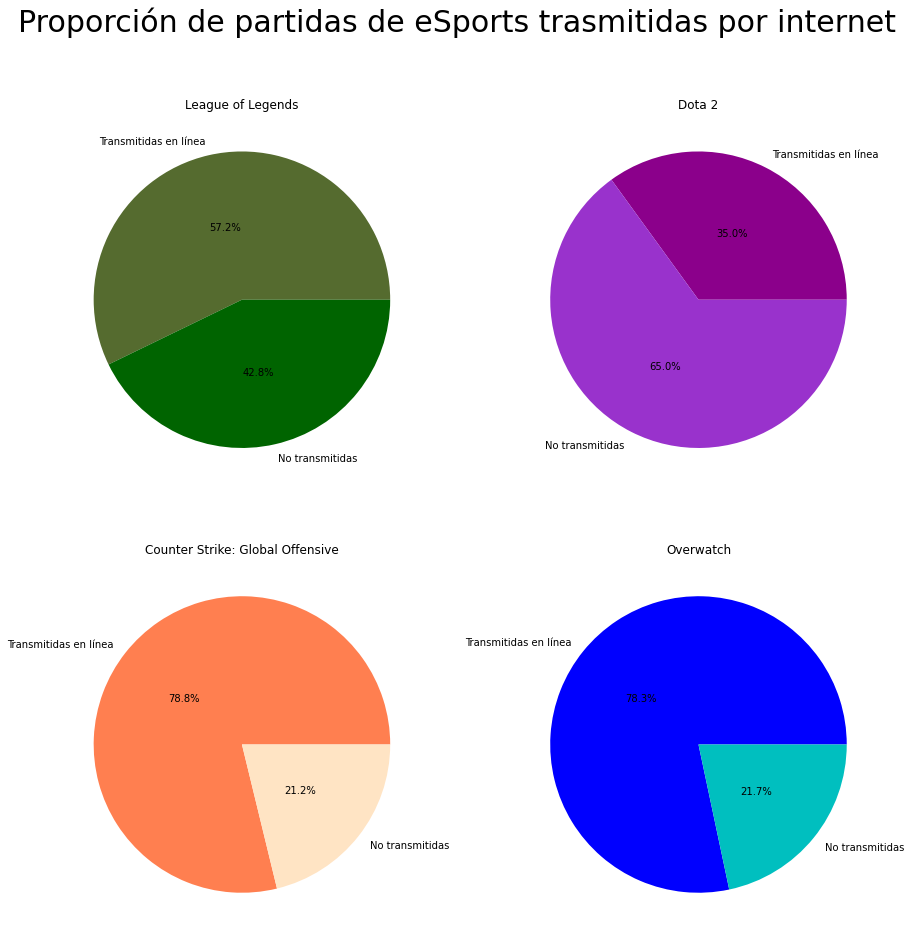

In [35]:
import matplotlib.pyplot as plt 

labels = ['Transmitidas en línea','No transmitidas']
# colores https://www.w3schools.com/colors/colors_names.asp
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)
fig.suptitle('Proporción de partidas de eSports trasmitidas por internet', fontsize = 30)
fig.set_figheight(15)
fig.set_figwidth(15)
ax1.pie(x=streams_lol, autopct="%.1f%%", labels=labels, pctdistance=0.5, colors= ('DarkOliveGreen','DarkGreen'))
ax1.set_title('League of Legends')
ax2.pie(x=streams_dota2, autopct="%.1f%%", labels=labels, pctdistance=0.5, colors= ('DarkMagenta','DarkOrchid'))
ax2.set_title('Dota 2')
ax3.pie(x=streams_csgo, autopct="%.1f%%", labels=labels, pctdistance=0.5, colors= ('Coral','Bisque'))
ax3.set_title('Counter Strike: Global Offensive')
ax4.pie(x=streams_ow, autopct="%.1f%%", labels=labels, pctdistance=0.5, colors= ('b','c'))
ax4.set_title('Overwatch')

En general tenemos un gráfico fácil de leer, los enfrentamientos para cada juego con transmitidos en más del 50% de los casos, siendo LoL el de menor proporción y CS:GO el de mayor proporción. 

Queda comprobado entonces que nuestros Dataframes forman un Dataset con gran potencial de explotación y con el que podemos obtener mucha información relacionada a eSports, pero aún nos falta responder una última pregunta para quedar satisfechos.